Tutorial based on https://www.youtube.com/watch?v=vV12dGe_Fho&t=937s&ab_channel=RobMulla

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

There are a few types of time series data:

1. Random Error - no recognizable pattern
2. Exponential growth
3. Linear Trend
4. seasonal Pattern
5. Seasonal Pattern and Linear Growth


In [146]:
df = pd.read_csv('PJME_hourly.csv')

In [147]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [148]:
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [149]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [150]:
df = df.set_index('Datetime')

In [151]:
df = df[~df.index.duplicated()]

In [152]:
color_pal = sns.color_palette()

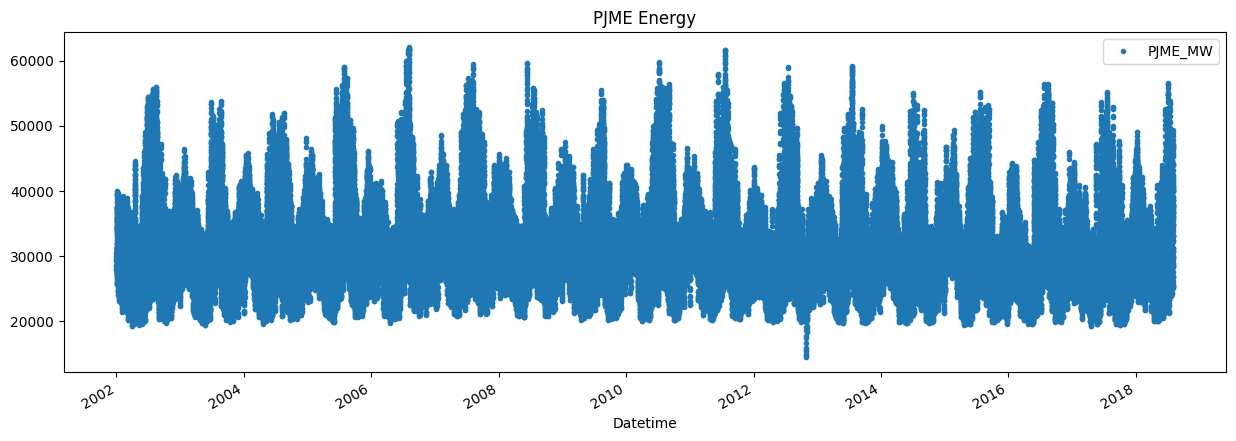

In [153]:
df.plot(style='.', figsize=(15,5), color=color_pal[0], title="PJME Energy")
plt.show()


# Train / Test Split

In [154]:
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


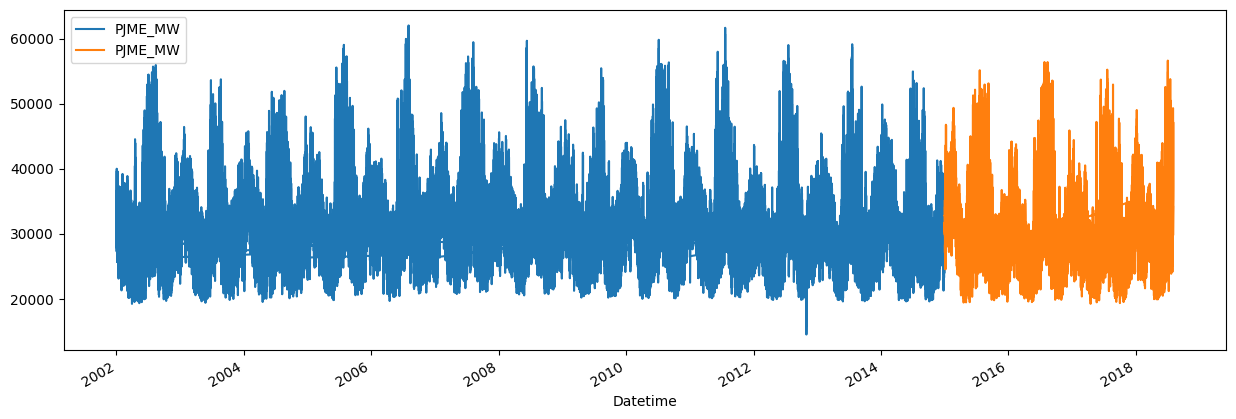

In [155]:
# Test split at Jan 2015
train = df.loc[df.index < '2015-01-01']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax= ax, label='Training Set')
test.plot(ax=ax, label='Test Set')
# ax.axvline('0')
plt.show()


In [156]:
train

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2014-01-01 20:00:00,36193.0
2014-01-01 21:00:00,35601.0
2014-01-01 22:00:00,34242.0


Look at the weekly data

<Axes: xlabel='Datetime'>

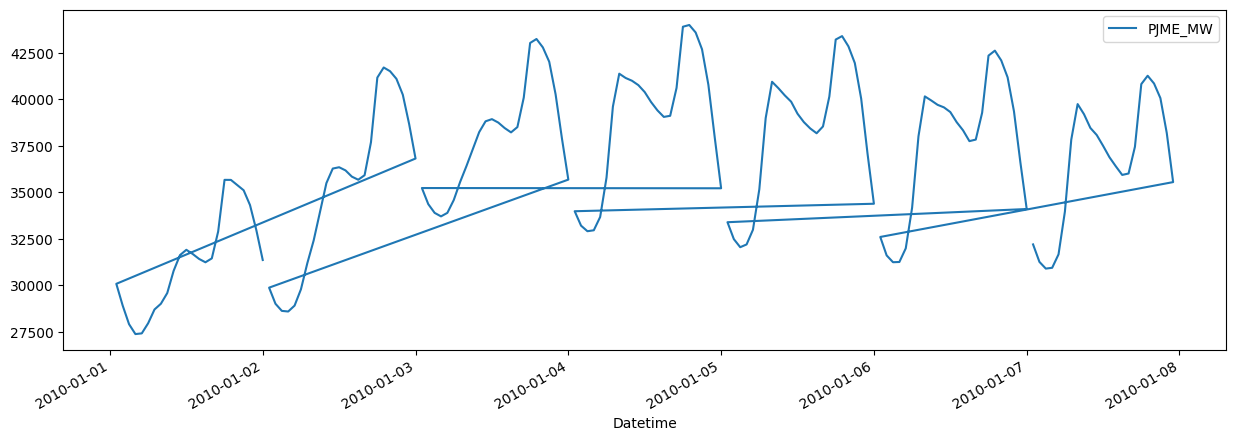

In [157]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15,5))

Observation: Two peaks per day, 1st of january is holiday

day_of_week begins on Monday according to docs

In [158]:
def create_features(df):
    """
    Create time series features based on time series index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayOfWeek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayOfYear'] = df.index.dayofyear
    
    return df

In [159]:
df = create_features(df)

Visualize Features / Target Relationship

Analysis of consumption on hour of day

<function matplotlib.pyplot.show(close=None, block=None)>

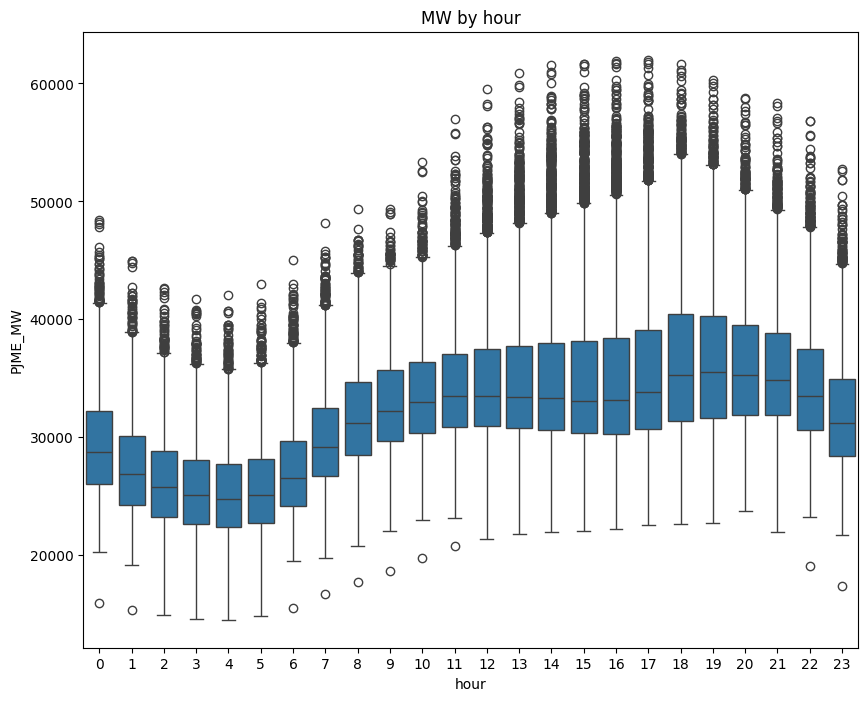

In [160]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by hour')
plt.show

Analysis by month

<function matplotlib.pyplot.show(close=None, block=None)>

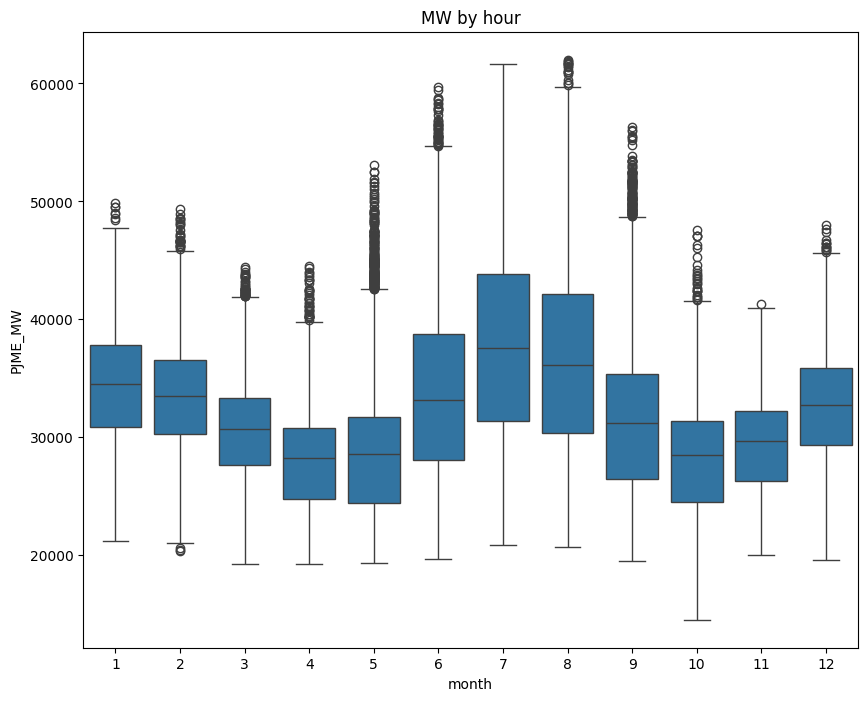

In [161]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month', y='PJME_MW')
ax.set_title('MW by hour')
plt.show

Create model

In [162]:
train

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2014-01-01 20:00:00,36193.0
2014-01-01 21:00:00,35601.0
2014-01-01 22:00:00,34242.0


In [163]:
test

,PJME_MW
Datetime,
2015-01-01 00:00:00,32802.0
2015-12-31 01:00:00,24305.0
2015-12-31 02:00:00,23156.0
2015-12-31 03:00:00,22514.0
2015-12-31 04:00:00,22330.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [164]:
train = create_features(train)
test = create_features(test)

In [165]:
df.columns

Index(['PJME_MW', 'hour', 'dayOfWeek', 'quarter', 'month', 'year',
       'dayOfYear'],
      dtype='object')

In [166]:
FEATURES = ['hour', 'dayOfWeek', 'quarter', 'month', 'year', 'dayOfYear']
TARGET = ['PJME_MW']

In [167]:
X_train = train[FEATURES]
Y_train = train[TARGET]

X_test = test[FEATURES]
Y_Test = test[TARGET]

In [168]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate = 0.01)
reg.fit(X_train, Y_train, 
        eval_set=[(X_train, Y_train), (X_test, Y_Test)],
        verbose=100)

[0]	validation_0-rmse:6407.33653	validation_1-rmse:6479.23813
[100]	validation_0-rmse:3912.11879	validation_1-rmse:4311.44579
[200]	validation_0-rmse:3245.57651	validation_1-rmse:3864.83143
[300]	validation_0-rmse:2997.35661	validation_1-rmse:3743.38043
[400]	validation_0-rmse:2832.90248	validation_1-rmse:3740.27671
[407]	validation_0-rmse:2819.25288	validation_1-rmse:3742.02888


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Feature Importance

In [169]:
FEATURES

['hour', 'dayOfWeek', 'quarter', 'month', 'year', 'dayOfYear']

In [170]:
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['Importance'])

<Axes: title={'center': 'Feature Importance'}>

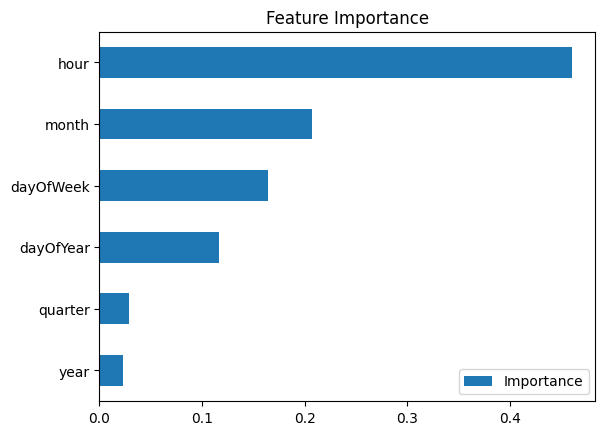

In [171]:
fi.sort_values('Importance').plot(kind='barh', title="Feature Importance")

# Forecast on test set 

In [172]:
test['prediction'] = reg.predict(X_test)

In [173]:
df= df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

In [174]:
df

,PJME_MW,hour,dayOfWeek,quarter,month,year,dayOfYear,prediction
Datetime,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,NaN
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,NaN
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,NaN
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,NaN
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,NaN
...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,38592.523438
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,38464.507812
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,36287.062500


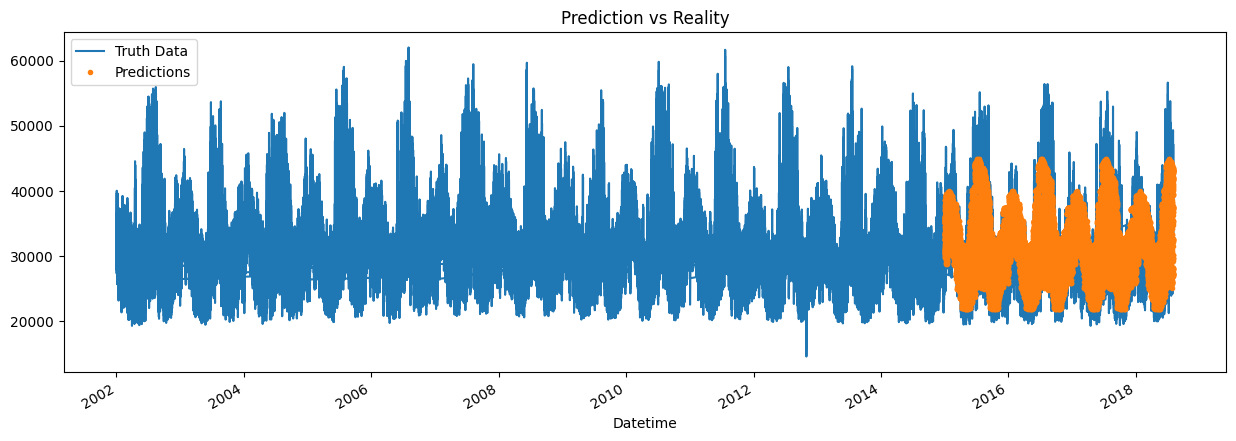

In [175]:
# Plot Datetime VS PJME_MW 
ax = df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title("Prediction vs Reality")
plt.show()

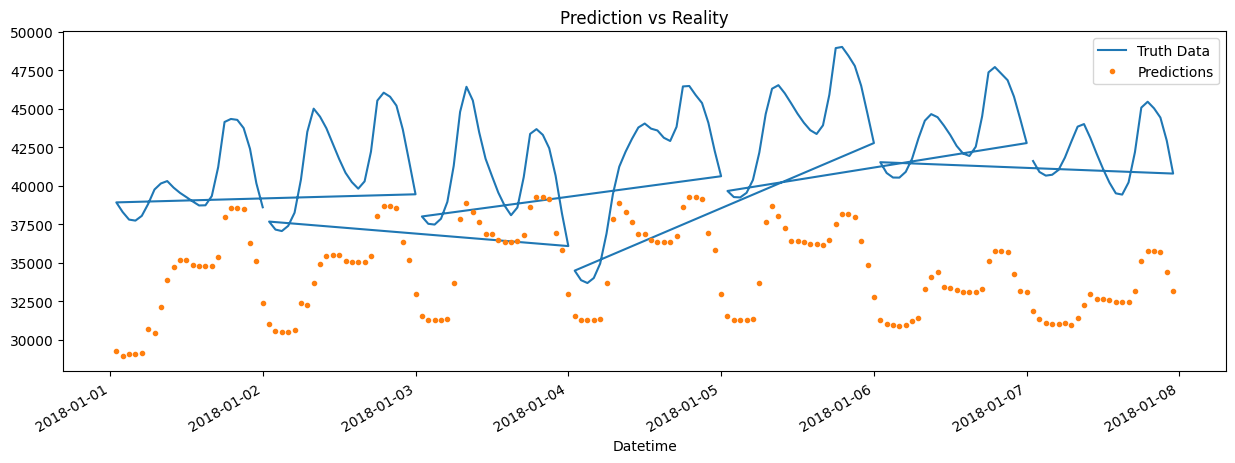

In [176]:
ax = df.loc[(df.index > '01-01-2018') & (df.index < '01-08-2018')]['PJME_MW'].plot(figsize=(15,5))
df.loc[(df.index > '01-01-2018') & (df.index < '01-08-2018')]['prediction'].plot(style='.')
# df['prediction']
plt.legend(['Truth Data', 'Predictions'])
ax.set_title("Prediction vs Reality")
plt.show()


In [177]:
np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))

3734.9144426391413

# Calculate Error

In [183]:
TARGET

['PJME_MW']

In [185]:
test['error'] = np.abs(test['PJME_MW'].sub(test['prediction']))

In [186]:
test

,PJME_MW,hour,dayOfWeek,quarter,month,year,dayOfYear,prediction,error
Datetime,,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,32443.345703,358.654297
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,28960.804688,4655.804688
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,27791.177734,4635.177734
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,27539.103516,5025.103516
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,27539.103516,5209.103516
...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,38592.523438,5691.476562
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,38464.507812,5286.492188
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,36287.062500,6114.937500


Look at best and worst days

In [189]:
test['date'] = test.index.date

Worst predicted days

In [192]:
test.groupby([('date')])['error'].mean().sort_values(ascending=False).head()

date
2016-08-13    13624.792155
2016-08-14    13335.710449
2016-09-10    11298.811361
2016-09-09    11125.013021
2016-08-12    10568.083659
Name: error, dtype: float64

Best predicted days

In [193]:
test.groupby([('date')])['error'].mean().sort_values(ascending=True).head()

date
2016-12-30    388.600423
2017-10-24    422.921061
2016-04-04    461.709961
2016-10-27    462.947835
2017-05-02    477.316406
Name: error, dtype: float64